In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from datetime import timedelta, datetime
import csv

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from scipy import stats
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, kruskal


from env import user, password, host
import flight_delay_acquire
import flight_delay_prepare

# Acquire

In [2]:
# Expanding the columns I can visualize
pd.set_option('display.max_columns', 500)

In [3]:
# Reading 2007.csv into a dataframe
df = pd.read_csv('~/codeup/external_data_tap/unzipped_data/2007.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453215 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay      

In [5]:
df

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,NaN,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,NaN,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,NaN,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,NaN,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453210,2007,12,15,6,1558.0,1605,1749.0,1736,DL,58,N670DN,111.0,91.0,80.0,13.0,-7.0,MCO,ATL,403,14,17,0,NaN,0,0,0,0,0,0
7453211,2007,12,15,6,1902.0,1851,2110.0,2105,DL,59,N829MH,248.0,254.0,221.0,5.0,11.0,ATL,SLC,1589,6,21,0,NaN,0,0,0,0,0,0
7453212,2007,12,15,6,1024.0,1025,1750.0,1735,DL,61,N623DL,266.0,250.0,233.0,15.0,-1.0,LAX,ATL,1946,14,19,0,NaN,0,0,0,15,0,0
7453213,2007,12,15,6,1353.0,1315,1658.0,1622,DL,62,N970DL,125.0,127.0,100.0,36.0,38.0,DFW,ATL,732,11,14,0,NaN,0,0,0,0,0,36


In [6]:
df.TaxiIn.isnull().sum()

0

In [9]:
var_dict = pd.read_csv('~/codeup/external_data_tap/unzipped_data/variable-descriptions.csv')
airports_df = pd.read_csv('~/codeup/external_data_tap/unzipped_data/airports.csv')
carriers_df = pd.read_csv('~/codeup/external_data_tap/unzipped_data/carriers.csv')
plane_df = pd.read_csv('~/codeup/external_data_tap/unzipped_data/plane-data.csv')


In [10]:
# Only implement after mvp is complete
airports_df

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944
...,...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,NC,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,PA,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,FL,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,NM,USA,35.083227,-108.791777


In [11]:
# Only implement after mvp is complete
carriers_df

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.
...,...,...
1486,ZW,Air Wisconsin Airlines Corp
1487,ZX,Air Georgian
1488,ZX (1),Airbc Ltd.
1489,ZY,Atlantic Gulf Airlines


In [12]:
# Only implement after mvp is complete
plane_df

,tailnum,type,manufacturer,issue_date,model,status,aircraft_type,engine_type,year
0,N050AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N051AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N052AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N054AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N055AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5024,N997DL,Corporation,MCDONNELL DOUGLAS AIRCRAFT CO,03/11/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1992
5025,N998AT,Corporation,BOEING,01/23/2003,717-200,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2002
5026,N998DL,Corporation,MCDONNELL DOUGLAS CORPORATION,04/02/1992,MD-88,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1992
5027,N999CA,Foreign Corporation,CANADAIR,07/09/2008,CL-600-2B19,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1998


In [13]:
print(var_dict.to_markdown())

|    |   Variable descriptions | Unnamed: 1        | Unnamed: 2                                                                |
|---:|------------------------:|:------------------|:--------------------------------------------------------------------------|
|  0 |                     nan | nan               | nan                                                                       |
|  1 |                     nan | Name              | Description                                                               |
|  2 |                       1 | Year              | 1987-2008                                                                 |
|  3 |                       2 | Month             | 12-Jan                                                                    |
|  4 |                       3 | DayofMonth        | 31-Jan                                                                    |
|  5 |                       4 | DayOfWeek         | 1 (Monday) - 7 (Sunday)                     

|    |   Variable descriptions | Unnamed: 1        | Unnamed: 2                                                                |
|---:|------------------------:|:------------------|:--------------------------------------------------------------------------|
|  0 |                     nan | nan               | nan                                                                       |
|  1 |                     nan | Name              | Description                                                               |
|  2 |                       1 | Year              | 1987-2008                                                                 |
|  3 |                       2 | Month             | 12-Jan                                                                    |
|  4 |                       3 | DayofMonth        | 31-Jan                                                                    |
|  5 |                       4 | DayOfWeek         | 1 (Monday) - 7 (Sunday)                                                   |
|  6 |                       5 | DepTime           | actual departure time (local, hhmm)                                       |
|  7 |                       6 | CRSDepTime        | scheduled departure time (local, hhmm)                                    |
|  8 |                       7 | ArrTime           | actual arrival time (local, hhmm)                                         |
|  9 |                       8 | CRSArrTime        | scheduled arrival time (local, hhmm)                                      |
| 10 |                       9 | UniqueCarrier     | unique carrier code                                                       |
| 11 |                      10 | FlightNum         | flight number                                                             |
| 12 |                      11 | TailNum           | plane tail number                                                         |
| 13 |                      12 | ActualElapsedTime | in minutes                                                                |
| 14 |                      13 | CRSElapsedTime    | in minutes                                                                |
| 15 |                      14 | AirTime           | in minutes                                                                |
| 16 |                      15 | ArrDelay          | arrival delay, in minutes                                                 |
| 17 |                      16 | DepDelay          | departure delay, in minutes                                               |
| 18 |                      17 | Origin            | origin IATA airport code                                                  |
| 19 |                      18 | Dest              | destination IATA airport code                                             |
| 20 |                      19 | Distance          | in miles                                                                  |
| 21 |                      20 | TaxiIn            | taxi in time, in minutes                                                  |
| 22 |                      21 | TaxiOut           | taxi out time in minutes                                                  |
| 23 |                      22 | Cancelled         | was the flight cancelled?                                                 |
| 24 |                      23 | CancellationCode  | reason for cancellation (A = carrier, B = weather, C = NAS, D = security) |
| 25 |                      24 | Diverted          | 1 = yes, 0 = no                                                           |
| 26 |                      25 | CarrierDelay      | in minutes                                                                |
| 27 |                      26 | WeatherDelay      | in minutes                                                                |
| 28 |                      27 | NASDelay          | in minutes                                                                |
| 29 |                      28 | SecurityDelay     | in minutes                                                                |
| 30 |                      29 | LateAircraftDelay | in minutes                                                                |

In [14]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,NaN,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,NaN,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,NaN,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,NaN,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,NaN,0,0,0,0,0,0


In [15]:
df.Month.value_counts()

8     653279
7     648560
3     639209
5     631609
10    629992
6     629280
1     621559
4     614648
12    614139
11    605149
9     600187
2     565604
Name: Month, dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453215 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay      

In [17]:
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime               160748
CRSDepTime                 0
ArrTime               177927
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum                   22
ActualElapsedTime     177927
CRSElapsedTime           994
AirTime               177927
ArrDelay              177927
DepDelay              160748
Origin                     0
Dest                       0
Distance                   0
TaxiIn                     0
TaxiOut                    0
Cancelled                  0
CancellationCode     7292466
Diverted                   0
CarrierDelay               0
WeatherDelay               0
NASDelay                   0
SecurityDelay              0
LateAircraftDelay          0
dtype: int64

In [18]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,NaN,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,NaN,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,NaN,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,NaN,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,NaN,0,0,0,0,0,0


# Preparation

### New Path
- drop all `ArrTime` nulls for simplicity

In [19]:
df = df[df['ArrTime'].notna()]

In [20]:
df = df.drop(columns='CancellationCode', axis =1)

In [21]:
df.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       int64  
 24  WeatherDelay       int64  
 25  NASDelay          

### Must convert `DepTime`, `CRSDepTime`, `ArrTime`, & `CRSArrTime`:
- To str
- Then, to_datetime
- Then, feature-engineer:
    - df.DepDiff = `CRSDepTime` - `DepTime`
    - df.ArrDiff = `CRSArrTime` - `ArrTime`

## Update:
**NOT ABLE TO FEATURE-ENGINEER THESE 2 FEATURES**\
Why: not able to do proper conversion, MUST move on with prep and explore

In [23]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,0,0,0,0,0,0


df["DepTime"] = df["DepTime"].astype(int)
df["ArrTime"] = df["ArrTime"].astype(int)
df["CRSDepTime"] = df["CRSDepTime"].astype(int)
df["CRSArrTime"] = df["CRSArrTime"].astype(int)

df["DepTime_str"] = df["DepTime"].astype(str)
df["ArrTime_str"] = df["ArrTime"].astype(str)
df["CRSDepTime_str"] = df["CRSDepTime"].astype(str)
df["CRSArrTime_str"] = df["CRSArrTime"].astype(str)

In [24]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,0,0,0,0,0,0


df["DepTime_str"].str.replace('[0-9]{2}$', '', regex=True)

df.CRSDepTime_str.info()

Convert original `str` dfs with `int` version; performing str.replace to remove "minute" characters
df['DepTime_int'] = df["DepTime_str"].str.replace('[0-9]{2}$', '', regex=True)
df['ArrTime_int'] = df["ArrTime_str"].str.replace('[0-9]{2}$', '', regex=True)
df['CRSDepTime_int'] = df["CRSDepTime_str"].str.replace('[0-9]{2}$', '', regex=True)
df['CRSArrTime_int'] = df["CRSArrTime_str"].str.replace('[0-9]{2}$', '', regex=True)

df['DepTime_int'] = df["DepTime_int"].astype(str)

df['DepTime_int'] = df["DepTime_int"].str.strip()


try:
    df['DepTime_int'] = df['DepTime_int'].astype(float)
except:
    print ("Fail")

df['DepTime_int'].info()

df['DepTime_int'].astype(int)

In [25]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,0,0,0,0,0,0


df['DepTime_int'] = df['DepTime_int'].astype(int)
df['ArrTime_int'] = df['ArrTime_int'].astype(int)
df['CRSDepTime_int'] = df['CRSDepTime_int'].astype(int)
df['CRSArrTime_int'] = df['CRSArrTime_int'].astype(int)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 28 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       int64  
 24  WeatherDelay       int64  
 25  NASDelay          

df['DepTime_int'] - df['CRSDepTime_int']

In [27]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,0,0,0,0,0,0
1,2007,1,1,1,1918.0,1905,2043.0,2035,WN,462,N370,85.0,90.0,74.0,8.0,13.0,SMF,PDX,479,5,6,0,0,0,0,0,0,0
2,2007,1,1,1,2206.0,2130,2334.0,2300,WN,1229,N685,88.0,90.0,73.0,34.0,36.0,SMF,PDX,479,6,9,0,0,3,0,0,0,31
3,2007,1,1,1,1230.0,1200,1356.0,1330,WN,1355,N364,86.0,90.0,75.0,26.0,30.0,SMF,PDX,479,3,8,0,0,23,0,0,0,3
4,2007,1,1,1,831.0,830,957.0,1000,WN,2278,N480,86.0,90.0,74.0,-3.0,1.0,SMF,PDX,479,3,9,0,0,0,0,0,0,0


In [28]:
# df['Day'] = df['DayofMonth']

In [29]:
df['date'] = pd.to_datetime(df[['Year','Month','Day']])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [31]:
df_datetime = df.set_index('date').sort_index()

In [32]:
df_datetime

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Day
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2007,1,1,1,1232.0,1225,1341.0,1340,WN,2891,N351,69.0,75.0,54.0,1.0,7.0,SMF,ONT,389,4,11,0,0,0,0,0,0,0,1
2007-01-01,2007,1,1,1,2304.0,2110,38.0,2240,B6,1608,N229JB,94.0,90.0,42.0,118.0,114.0,JFK,PWM,274,2,50,0,0,0,0,9,0,109,1
2007-01-01,2007,1,1,1,2011.0,1740,2148.0,1905,B6,1606,N247JB,97.0,85.0,50.0,163.0,151.0,JFK,PWM,274,2,45,0,0,13,0,12,0,138,1
2007-01-01,2007,1,1,1,1347.0,1330,1507.0,1445,B6,1604,N190JB,80.0,75.0,51.0,22.0,17.0,JFK,PWM,274,5,24,0,0,17,0,5,0,0,1
2007-01-01,2007,1,1,1,1008.0,915,1107.0,1035,B6,1600,N236JB,59.0,80.0,45.0,32.0,53.0,JFK,PWM,274,2,12,0,0,32,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-31,2007,12,31,1,1455.0,1425,1752.0,1730,UA,219,N807UA,357.0,365.0,339.0,22.0,30.0,IAD,SFO,2419,7,11,0,0,22,0,0,0,0,31
2007-12-31,2007,12,31,1,1530.0,1455,1706.0,1652,EV,4795,N828AS,96.0,117.0,83.0,14.0,35.0,ATL,ABE,692,3,10,0,0,0,0,0,0,0,31
2007-12-31,2007,12,31,1,951.0,1000,1103.0,1120,MQ,4779,N733KR,72.0,80.0,58.0,-17.0,-9.0,DCA,BOS,399,4,10,0,0,0,0,0,0,0,31


In [33]:
df.UniqueCarrier.value_counts()

WN    1156958
AA     613836
OO     582871
MQ     516205
UA     477090
US     475583
DL     468323
XE     422305
NW     405872
CO     319138
YV     282585
EV     276617
FL     259869
9E     250186
OH     224471
B6     187116
AS     157123
F9      97248
HA      55935
AQ      45957
Name: UniqueCarrier, dtype: int64

In [34]:
df = df.drop(columns = 'Day')


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [36]:
df.CarrierDelay.value_counts()

0       6460366
15        28492
6         26084
7         24544
16        23999
         ...   
803           1
1093          1
977           1
976           1
542           1
Name: CarrierDelay, Length: 1045, dtype: int64

In [37]:
df.DepDelay.value_counts()

 0.0       624472
-5.0       519790
-3.0       510450
-2.0       507824
-4.0       476945
            ...  
 1109.0         1
 1115.0         1
 1280.0         1
 1406.0         1
 729.0          1
Name: DepDelay, Length: 1220, dtype: int64

In [38]:
df.ArrDelay.value_counts()

-5.0       226715
-4.0       221078
-6.0       219985
-7.0       218412
-3.0       214438
            ...  
 765.0          1
-157.0          1
 1203.0         1
 869.0          1
 813.0          1
Name: ArrDelay, Length: 1232, dtype: int64

In [39]:
df['total_delay'] = (df['ArrDelay'] + df['DepDelay'])

In [40]:
df.total_delay.value_counts()

-8.0       171854
-9.0       171372
-10.0      171319
-7.0       170592
-6.0       168288
            ...  
 2425.0         1
 1661.0         1
 1126.0         1
 2386.0         1
 1200.0         1
Name: total_delay, Length: 2081, dtype: int64

In [41]:
df.total_delay.describe()

count    7.275288e+06
mean     2.155426e+01
std      7.406518e+01
min     -6.170000e+02
25%     -1.200000e+01
50%     -1.000000e+00
75%      2.300000e+01
max      5.199000e+03
Name: total_delay, dtype: float64

In [42]:
# df.total_delay.plot()

In [43]:
# Useless column
df.Diverted.value_counts()

0    7275288
Name: Diverted, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [45]:
# df = df.drop(columns = 'Diverted')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [47]:
df_samp = df_datetime.sample(100000)

In [48]:
df_micro_samp = df_datetime.sample(5000)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            float64       
 5   CRSDepTime         int64         
 6   ArrTime            float64       
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  float64       
 12  CRSElapsedTime     float64       
 13  AirTime            float64       
 14  ArrDelay           float64       
 15  DepDelay           float64       
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [50]:
df.ArrDelay.value_counts()

-5.0       226715
-4.0       221078
-6.0       219985
-7.0       218412
-3.0       214438
            ...  
 765.0          1
-157.0          1
 1203.0         1
 869.0          1
 813.0          1
Name: ArrDelay, Length: 1232, dtype: int64

In [51]:
df["DepTime"] = df["DepTime"].astype(int)

In [52]:
df["ArrTime"] = df["ArrTime"].astype(int)
df["ActualElapsedTime"] = df["ActualElapsedTime"].astype(int)
df["CRSElapsedTime"] = df["CRSElapsedTime"].astype(int)
df["ArrDelay"] = df["ArrDelay"].astype(int)
df["DepDelay"] = df["DepDelay"].astype(int)
df["total_delay"] = df["total_delay"].astype(int)
df["AirTime"] = df["AirTime"].astype(int)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            int64         
 5   CRSDepTime         int64         
 6   ArrTime            int64         
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  int64         
 12  CRSElapsedTime     int64         
 13  AirTime            int64         
 14  ArrDelay           int64         
 15  DepDelay           int64         
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            int64         
 5   CRSDepTime         int64         
 6   ArrTime            int64         
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  int64         
 12  CRSElapsedTime     int64         
 13  AirTime            int64         
 14  ArrDelay           int64         
 15  DepDelay           int64         
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut            int64

### Rename columns

In [55]:
df = df.rename(columns = {'DayofMonth':'dayofmonth','DayOfWeek':'weekday','DepTime':'depart', 'CRSDepTime':'scheduled_depart', 'ArrTime':'arrive', 'CRSArrTime':'scheduled_arrive', 'ActualElapsedTime':'total_time', 'CRSElapsedTime':'scheduled_total_time'})

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7275288 entries, 0 to 7453214
Data columns (total 30 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Year                  int64         
 1   Month                 int64         
 2   dayofmonth            int64         
 3   weekday               int64         
 4   depart                int64         
 5   scheduled_depart      int64         
 6   arrive                int64         
 7   scheduled_arrive      int64         
 8   UniqueCarrier         object        
 9   FlightNum             int64         
 10  TailNum               object        
 11  total_time            int64         
 12  scheduled_total_time  int64         
 13  AirTime               int64         
 14  ArrDelay              int64         
 15  DepDelay              int64         
 16  Origin                object        
 17  Dest                  object        
 18  Distance              int64         
 19  

In [57]:
df.Origin.nunique()

304

In [58]:
df.head()

,Year,Month,dayofmonth,weekday,depart,scheduled_depart,arrive,scheduled_arrive,UniqueCarrier,FlightNum,TailNum,total_time,scheduled_total_time,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,0,0,0,0,0,0,2007-01-01,8
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,0,0,0,0,0,0,2007-01-01,21
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,0,3,0,0,0,31,2007-01-01,70
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,0,23,0,0,0,3,2007-01-01,56
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,0,0,0,0,0,0,2007-01-01,-2


### One-Hot Encode Variables
- Month
- DON'T FOR NOW:dayofmonth
- weekday
- UniqueCarrier

#### OHE for `Month`

In [59]:
df['month'] = df['Month']

In [60]:
df = pd.get_dummies(df, prefix='month', columns=['month'])

In [61]:
df.head()

,Year,Month,dayofmonth,weekday,depart,scheduled_depart,arrive,scheduled_arrive,UniqueCarrier,FlightNum,TailNum,total_time,scheduled_total_time,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,0,0,0,0,0,0,2007-01-01,8,1,0,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,0,0,0,0,0,0,2007-01-01,21,1,0,0,0,0,0,0,0,0,0,0,0
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,0,3,0,0,0,31,2007-01-01,70,1,0,0,0,0,0,0,0,0,0,0,0
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,0,23,0,0,0,3,2007-01-01,56,1,0,0,0,0,0,0,0,0,0,0,0
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,0,0,0,0,0,0,2007-01-01,-2,1,0,0,0,0,0,0,0,0,0,0,0


#### OHE for `weekday`

In [64]:
df['WEEKday'] = df['weekday']

In [66]:
df = pd.get_dummies(df, prefix='weekday', columns=['WEEKday'])

In [67]:
df.head()

,Year,Month,dayofmonth,weekday,depart,scheduled_depart,arrive,scheduled_arrive,UniqueCarrier,FlightNum,TailNum,total_time,scheduled_total_time,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,0,0,0,0,0,0,2007-01-01,8,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,0,0,0,0,0,0,2007-01-01,21,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,0,3,0,0,0,31,2007-01-01,70,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,0,23,0,0,0,3,2007-01-01,56,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,0,0,0,0,0,0,2007-01-01,-2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### OHE for `UniqueCarrier`

In [68]:
df['carrier'] = df['UniqueCarrier']

In [69]:
df = pd.get_dummies(df, prefix='uniq_carr', columns=['carrier'])

In [70]:
df.head()

,Year,Month,dayofmonth,weekday,depart,scheduled_depart,arrive,scheduled_arrive,UniqueCarrier,FlightNum,TailNum,total_time,scheduled_total_time,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,uniq_carr_9E,uniq_carr_AA,uniq_carr_AQ,uniq_carr_AS,uniq_carr_B6,uniq_carr_CO,uniq_carr_DL,uniq_carr_EV,uniq_carr_F9,uniq_carr_FL,uniq_carr_HA,uniq_carr_MQ,uniq_carr_NW,uniq_carr_OH,uniq_carr_OO,uniq_carr_UA,uniq_carr_US,uniq_carr_WN,uniq_carr_XE,uniq_carr_YV
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,0,0,0,0,0,0,2007-01-01,8,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,0,0,0,0,0,0,2007-01-01,21,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,0,3,0,0,0,31,2007-01-01,70,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,0,23,0,0,0,3,2007-01-01,56,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,0,0,0,0,0,0,2007-01-01,-2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Bin Variables
- dayofmonth binned into 4 equal parts (resulting in 4 weeks, CREATING `week_of_month`
- total_delay binned into 'short', 'medium', and 'long' delays (CREATING *all 3 of those columns*)



In [72]:
df.dayofmonth.info()

<class 'pandas.core.series.Series'>
Int64Index: 7275288 entries, 0 to 7453214
Series name: dayofmonth
Non-Null Count    Dtype
--------------    -----
7275288 non-null  int64
dtypes: int64(1)
memory usage: 111.0 MB


In [76]:
df.dayofmonth.value_counts()

12    244471
19    244032
26    243629
9     243276
5     242562
18    242425
20    242202
7     241927
21    240426
11    240089
8     239697
23    239667
6     239558
4     239215
2     239132
28    238554
16    238047
15    237695
25    237367
14    236934
27    236881
10    236601
17    236221
1     235504
22    235409
3     234939
13    234806
24    233252
30    222279
29    219914
31    138577
Name: dayofmonth, dtype: int64

In [78]:
df['week_of_month'] = pd.cut(x=df['dayofmonth'], bins = [0, 8, 16, 23, 31], labels = ['week_1', 'week_2', 'week_3', 'week_4'])

In [80]:
df

,Year,Month,dayofmonth,weekday,depart,scheduled_depart,arrive,scheduled_arrive,UniqueCarrier,FlightNum,TailNum,total_time,scheduled_total_time,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,uniq_carr_9E,uniq_carr_AA,uniq_carr_AQ,uniq_carr_AS,uniq_carr_B6,uniq_carr_CO,uniq_carr_DL,uniq_carr_EV,uniq_carr_F9,uniq_carr_FL,uniq_carr_HA,uniq_carr_MQ,uniq_carr_NW,uniq_carr_OH,uniq_carr_OO,uniq_carr_UA,uniq_carr_US,uniq_carr_WN,uniq_carr_XE,uniq_carr_YV,week_of_month
0,2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,0,0,0,0,0,0,2007-01-01,8,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,week_1
1,2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,0,0,0,0,0,0,2007-01-01,21,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,week_1
2,2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,0,3,0,0,0,31,2007-01-01,70,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,week_1
3,2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,0,23,0,0,0,3,2007-01-01,56,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,week_1
4,2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,0,0,0,0,0,0,2007-01-01,-2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,week_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7453210,2007,12,15,6,1558,1605,1749,1736,DL,58,N670DN,111,91,80,13,-7,MCO,ATL,403,14,17,0,0,0,0,0,0,0,2007-12-15,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,week_2
7453211,2007,12,15,6,1902,1851,2110,2105,DL,59,N829MH,248,254,221,5,11,ATL,SLC,1589,6,21,0,0,0,0,0,0,0,2007-12-15,16,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,week_2
7453212,2007,12,15,6,1024,1025,1750,1735,DL,61,N623DL,266,250,233,15,-1,LAX,ATL,1946,14,19,0,0,0,0,15,0,0,2007-12-15,14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,week_2
7453213,2007,12,15,6,1353,1315,1658,1622,DL,62,N970DL,125,127,100,36,38,DFW,ATL,732,11,14,0,0,0,0,0,0,36,2007-12-15,74,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,week_2


#### Binning total_delay?

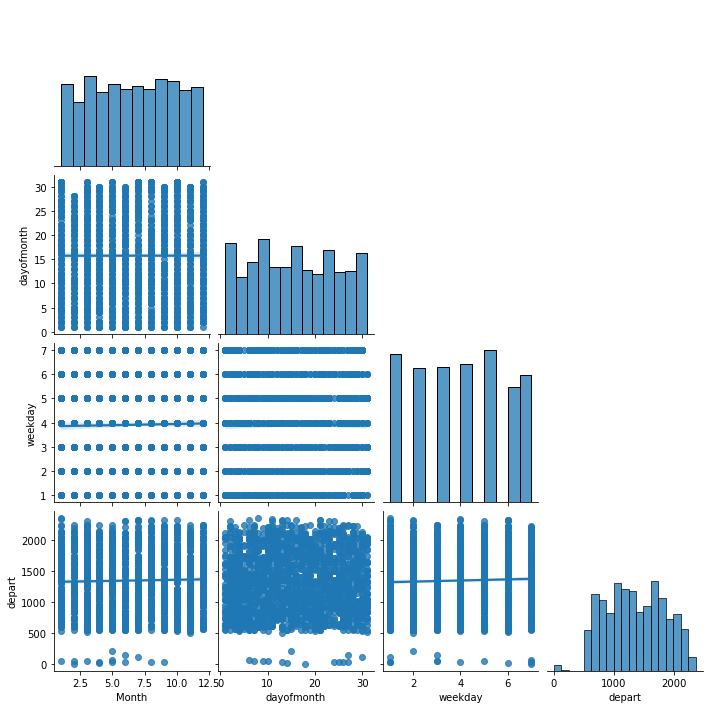

In [ ]:
# Creating a snapshot of our data, variables, and their relationships
sns.pairplot(df.sample(2000), kind='reg', vars = ['Month','dayofmonth','weekday', 'depart'], corner=True)

In [ ]:
train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)

In [ ]:
print(train.shape)
print(validate.shape)
print(test.shape)

(4074161, 29)
(1746069, 29)
(1455058, 29)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074161 entries, 3312646 to 3271075
Data columns (total 29 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            int64         
 5   CRSDepTime         int64         
 6   ArrTime            int64         
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  int64         
 12  CRSElapsedTime     int64         
 13  AirTime            int64         
 14  ArrDelay           int64         
 15  DepDelay           int64         
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut           

In [ ]:
cat_cols = ['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'location']
cont_cols = ['total_delay', 'DayofMonth', 'DayOfWeek', 'DepTime']

In [ ]:
# Creating a plot loop that iterates through all combinations of variables
def plot_categorical_and_continuous_vars(train, cat_cols, cont_cols):
    # train_sample = train.sample(5000)
    for cont in cont_cols:
        for cat in cat_cols:
            fig = plt.figure(figsize= (20, 10))
            fig.suptitle(f'{cont} vs {cat}')
            

            plt.subplot(131)
            sns.stripplot(data=train, x = cat, y = cont)
           

            plt.subplot(1, 3, 3)
            sns.boxplot(data = train, x = cont, hue = cat)
            
            
            plt.subplot(1, 3, 2)
            sns.barplot(data = train, x = cat, y = cont)

KeyboardInterrupt: 

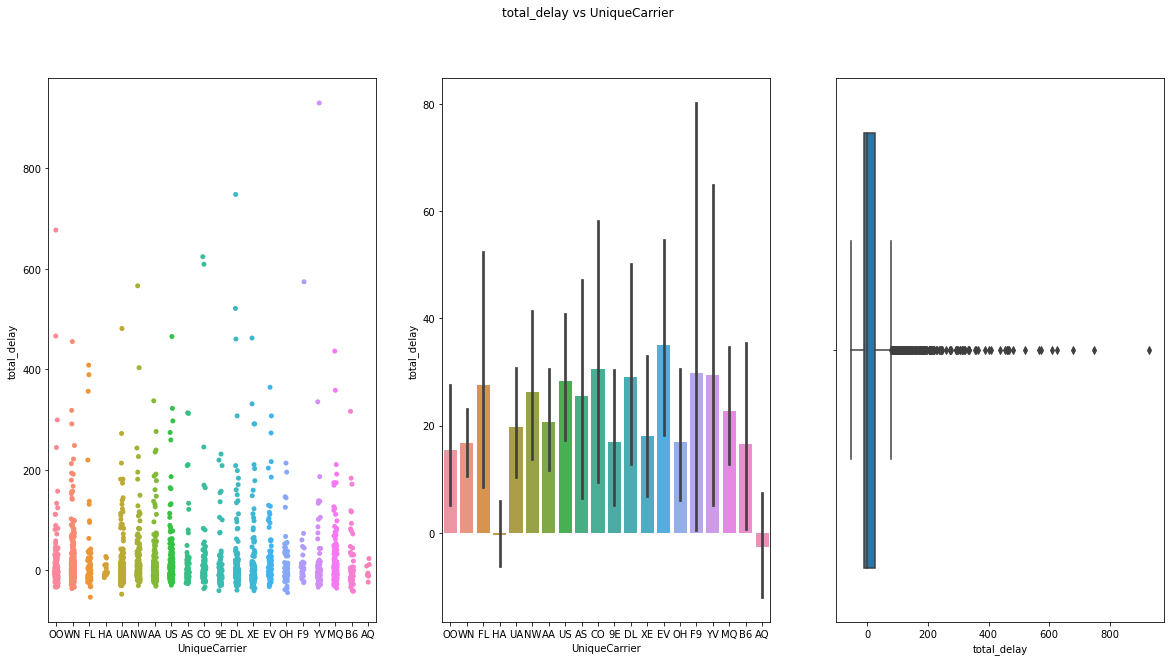

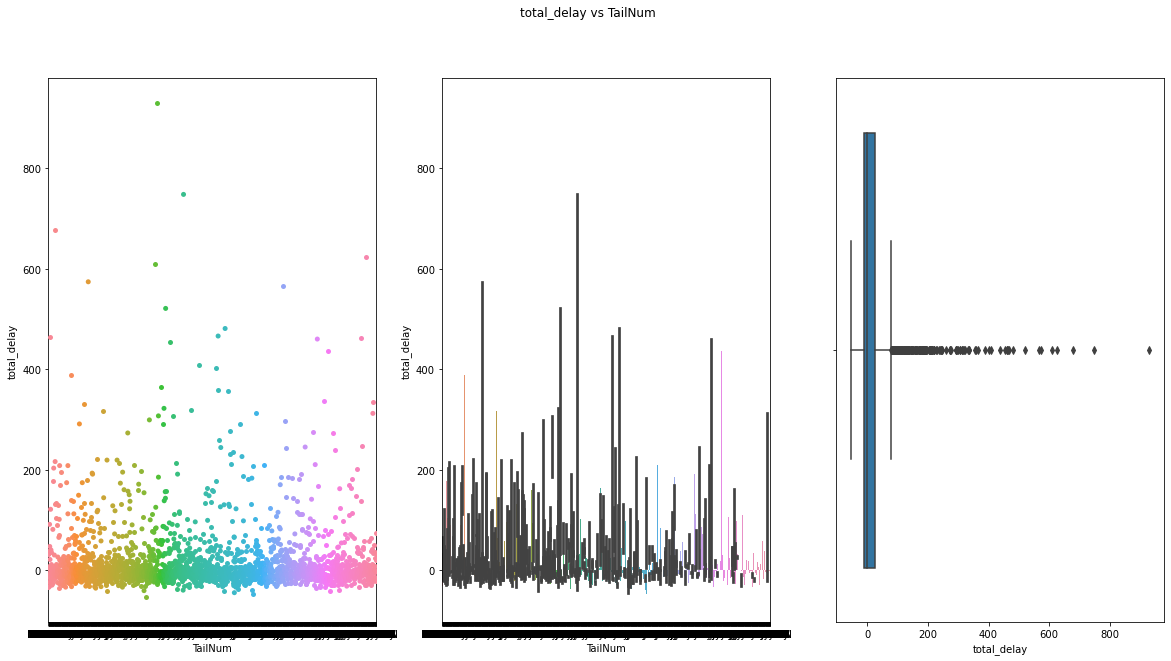

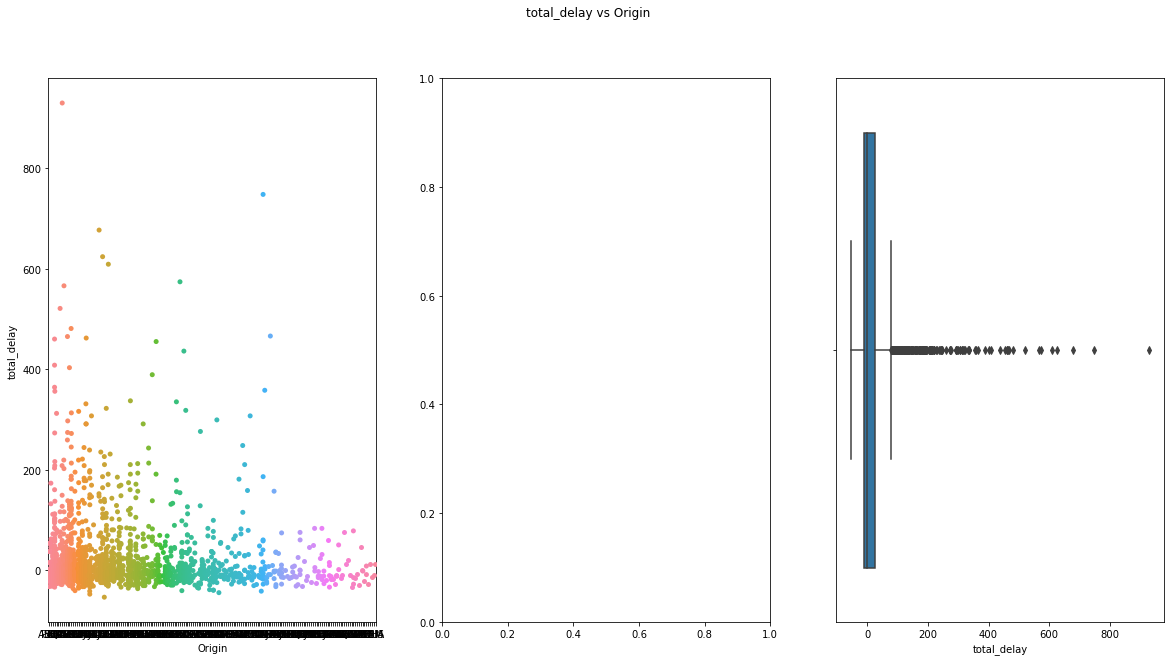

In [ ]:
# taking wayyy too long to run
# plot_categorical_and_continuous_vars(train.sample(2000), cat_cols, cont_cols)

In [ ]:
train_sm_sample = train.sample(2000)

In [ ]:
plt.figure()
sns.relplot(x='Month', y='total_delay', data=train_sm_sample, kind='scatter')

In [ ]:
plt.figure()
sns.relplot(x='DayofMonth', y='total_delay', data=train_sm_sample, kind='scatter')

In [ ]:
plt.figure()
sns.relplot(x='DayOfWeek', y='total_delay', data=train_sm_sample, kind='scatter')

In [ ]:
# plt.figure()
# sns.lmplot(x='DayofMonth', y='total_delay', data=train_sm_sample, scatter=True, hue=None)

In [ ]:
# plt.figure()
# sns.jointplot(x='DayOfWeek', y='total_delay', data=train_sm_sample, kind='scatter')

In [ ]:
train.DepTime

3312646    1507
2961834    1243
4322515    1440
1897002     923
7078174    1904
           ... 
4203105     615
4835231    2133
2375670    1232
90630      2005
3271075    1643
Name: DepTime, Length: 4074161, dtype: int64

In [ ]:
train.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,date,total_delay
3312646,2007,6,20,3,1507,1220,1640,1348,UA,311,N827UA,93,88,59,172,167,SFO,SNA,372,5,29,0,167,0,5,0,0,2007-06-20,339
2961834,2007,5,14,1,1243,1210,1508,1440,AA,1207,N3CYAA,145,150,128,28,33,DCA,MIA,920,5,12,0,9,0,0,0,19,2007-05-14,61
4322515,2007,7,6,5,1440,1403,1850,1800,CO,1550,N16618,190,177,169,50,37,MCI,EWR,1092,7,14,0,0,0,50,0,0,2007-07-06,87
1897002,2007,4,23,1,923,920,1055,1050,WN,916,N632SW,92,90,76,5,3,SAN,OAK,446,4,12,0,0,0,0,0,0,2007-04-23,8
7078174,2007,12,17,1,1904,1800,2221,2122,UA,540,N307UA,137,142,110,59,64,ORD,BOS,867,7,20,0,59,0,0,0,0,2007-12-17,123


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074161 entries, 3312646 to 3271075
Data columns (total 29 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Year               int64         
 1   Month              int64         
 2   DayofMonth         int64         
 3   DayOfWeek          int64         
 4   DepTime            int64         
 5   CRSDepTime         int64         
 6   ArrTime            int64         
 7   CRSArrTime         int64         
 8   UniqueCarrier      object        
 9   FlightNum          int64         
 10  TailNum            object        
 11  ActualElapsedTime  int64         
 12  CRSElapsedTime     int64         
 13  AirTime            int64         
 14  ArrDelay           int64         
 15  DepDelay           int64         
 16  Origin             object        
 17  Dest               object        
 18  Distance           int64         
 19  TaxiIn             int64         
 20  TaxiOut           